# FloodML: Impact of Water-Level Features on Model Performance

This notebook compares model performance **without** vs **with** water-level features on the same train/test split, and quantifies their impact using a set of academically strong analyses and visuals.

- Dataset: `data/enhanced_training_data.csv` (fallback: `FloodML-master/data/enhanced_training_data.csv`)
- Target: `flood_class` (0/1)
- Water-level features considered: `avg_reservoir_fill`, `max_reservoir_fill`, `reservoir_risk_score`, `reservoirs_above_danger`
- Model: `RandomForestClassifier(n_estimators=150, criterion="entropy", random_state=42)`

Sections:
1. Train/test split and baseline comparison (WITHOUT vs WITH water features)
2. Confusion matrices, ROC and PR curves
3. Calibration (probability reliability)
4. Feature and permutation importance (+ grouped importance)
5. Statistical significance (McNemar) + bootstrap CIs for metric deltas


Metrics WITHOUT water features: {'accuracy': 0.859375, 'precision': 0.8, 'recall': 0.7619047619047619, 'f1': 0.7804878048780488}
Metrics WITH water features: {'accuracy': 0.984375, 'precision': 0.9545454545454546, 'recall': 1.0, 'f1': 0.9767441860465116}
Delta (with - without): {'accuracy': 0.125, 'precision': 0.15454545454545454, 'recall': 0.23809523809523814, 'f1': 0.19625638116846278}


,Without water,With water
accuracy,0.859375,0.984375
precision,0.800000,0.954545
recall,0.761905,1.000000
f1,0.780488,0.976744


C:\Users\karan\AppData\Local\Temp\ipykernel_20732\2262384806.py:78: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_cmp.T, ci=None)
C:\Users\karan\AppData\Local\Temp\ipykernel_20732\2262384806.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Metric')


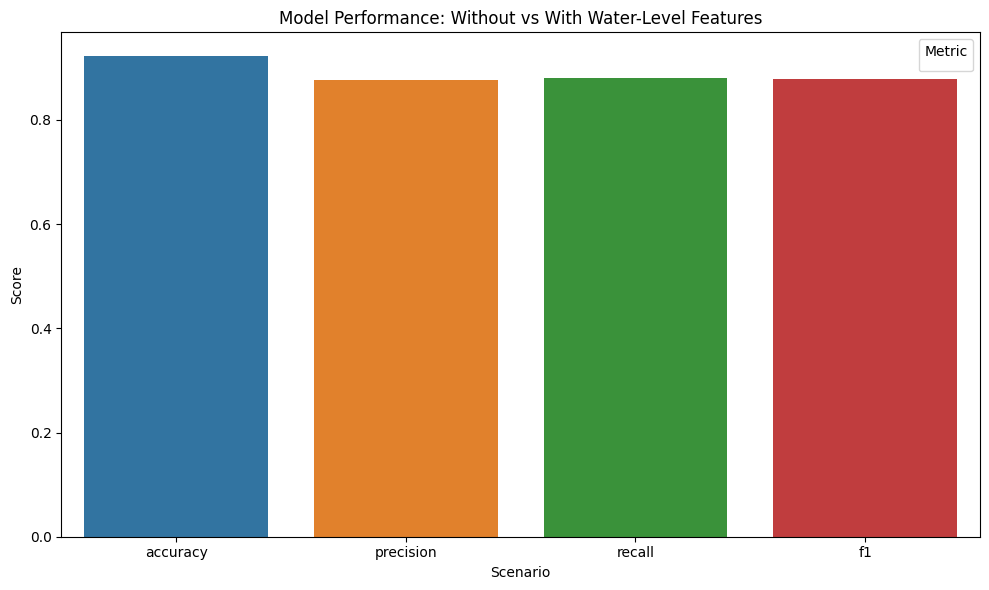

,with - without
accuracy,0.125000
precision,0.154545
recall,0.238095
f1,0.196256


In [1]:
# Section 1: Train/test split and baseline comparison (WITHOUT vs WITH water features)
# If needed, install plotting libs in your environment:
# %pip install matplotlib seaborn scikit-learn

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1) Load data (robust path resolution)
data_path = None
for cand in ['data/enhanced_training_data.csv', os.path.join('FloodML-master', 'data', 'enhanced_training_data.csv')]:
    if os.path.exists(cand):
        data_path = cand
        break
assert data_path is not None, 'enhanced_training_data.csv not found in expected locations'

data = pd.read_csv(data_path)
assert 'flood_class' in data.columns, "Expected 'flood_class' target in dataset"
y = data['flood_class']
X_all = data.drop('flood_class', axis=1)

# 2) Define water-level features and intersect with available columns
water_features = [
    'avg_reservoir_fill',
    'max_reservoir_fill',
    'reservoir_risk_score',
    'reservoirs_above_danger'
 ]
water_features_present = [c for c in water_features if c in X_all.columns]

# 3) Single train/test split used by both scenarios
X_train_all, X_test_all, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, stratify=y, random_state=42
)

# 4) Build feature sets
X_train_with = X_train_all.copy(); X_test_with = X_test_all.copy()
X_train_without = X_train_all.drop(columns=water_features_present, errors='ignore')
X_test_without = X_test_all.drop(columns=water_features_present, errors='ignore')

# 5) Helper: train and evaluate a model
def train_and_eval(Xtr, ytr, Xte, yte):
    clf = RandomForestClassifier(n_estimators=150, criterion='entropy', random_state=42)
    clf.fit(Xtr, ytr)
    preds = clf.predict(Xte)
    return clf, {
        'accuracy': accuracy_score(yte, preds),
        'precision': precision_score(yte, preds, zero_division=0),
        'recall': recall_score(yte, preds, zero_division=0),
        'f1': f1_score(yte, preds, zero_division=0),
    }, preds

# 6) Metrics for both scenarios
model_without, metrics_without, y_pred_without = train_and_eval(X_train_without, y_train, X_test_without, y_test)
model_with, metrics_with, y_pred_with = train_and_eval(X_train_with, y_train, X_test_with, y_test)

# Probabilities (if supported)
y_proba_with = model_with.predict_proba(X_test_with)[:, 1] if hasattr(model_with, 'predict_proba') else None
y_proba_without = model_without.predict_proba(X_test_without)[:, 1] if hasattr(model_without, 'predict_proba') else None

print('Metrics WITHOUT water features:', metrics_without)
print('Metrics WITH water features:', metrics_with)

# 7) Delta (with - without)
delta = {k: metrics_with[k] - metrics_without[k] for k in metrics_with}
print('Delta (with - without):', delta)

# 8) Tabulate and plot comparison
df_cmp = pd.DataFrame.from_dict({'Without water': metrics_without, 'With water': metrics_with})
display(df_cmp)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_cmp.T, ci=None)
plt.title('Model Performance: Without vs With Water-Level Features')
plt.ylabel('Score')
plt.xlabel('Scenario')
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

display(pd.DataFrame(delta, index=['with - without']).T)


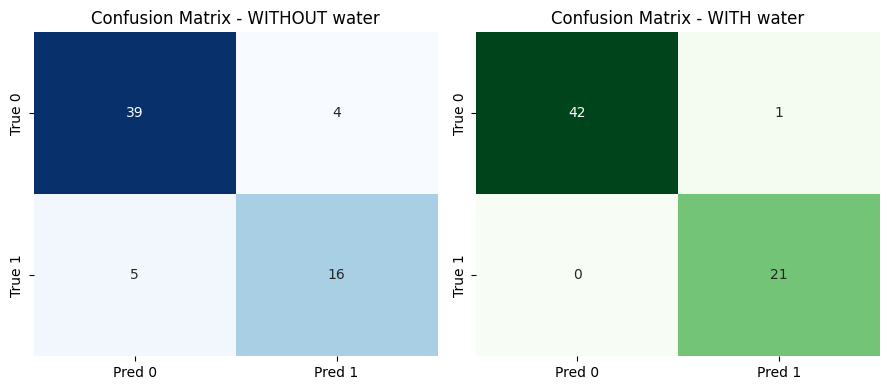

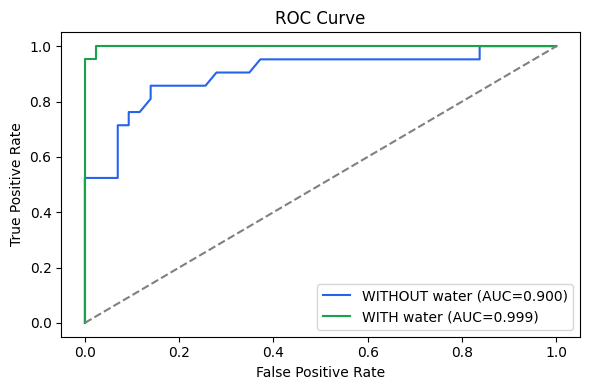

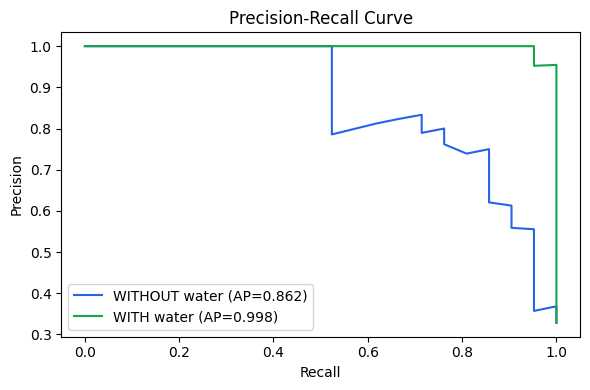

WITHOUT water features:               precision    recall  f1-score   support

           0     0.8864    0.9070    0.8966        43
           1     0.8000    0.7619    0.7805        21

    accuracy                         0.8594        64
   macro avg     0.8432    0.8344    0.8385        64
weighted avg     0.8580    0.8594    0.8585        64

WITH water features:               precision    recall  f1-score   support

           0     1.0000    0.9767    0.9882        43
           1     0.9545    1.0000    0.9767        21

    accuracy                         0.9844        64
   macro avg     0.9773    0.9884    0.9825        64
weighted avg     0.9851    0.9844    0.9845        64



In [2]:
# Section 2: Confusion matrices, ROC and Precision-Recall curves
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, classification_report

# Confusion matrices
cm_with = confusion_matrix(y_test, y_pred_with)
cm_without = confusion_matrix(y_test, y_pred_without)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.heatmap(cm_without, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'], ax=axes[0])
axes[0].set_title('Confusion Matrix - WITHOUT water')
sns.heatmap(cm_with, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'], ax=axes[1])
axes[1].set_title('Confusion Matrix - WITH water')
plt.tight_layout(); plt.show()

# ROC curves (if probas available)
if (y_proba_with is not None) and (y_proba_without is not None):
    fpr_w, tpr_w, _ = roc_curve(y_test, y_proba_with)
    fpr_wo, tpr_wo, _ = roc_curve(y_test, y_proba_without)
    auc_w = roc_auc_score(y_test, y_proba_with)
    auc_wo = roc_auc_score(y_test, y_proba_without)

    plt.figure(figsize=(6,4))
    plt.plot(fpr_wo, tpr_wo, label=f"WITHOUT water (AUC={auc_wo:.3f})", color="#2563eb")
    plt.plot(fpr_w, tpr_w, label=f"WITH water (AUC={auc_w:.3f})", color="#16a34a")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve'); plt.legend(); plt.tight_layout(); plt.show()

    # Precision-Recall
    p_w, r_w, _ = precision_recall_curve(y_test, y_proba_with)
    p_wo, r_wo, _ = precision_recall_curve(y_test, y_proba_without)
    ap_w = average_precision_score(y_test, y_proba_with)
    ap_wo = average_precision_score(y_test, y_proba_without)

    plt.figure(figsize=(6,4))
    plt.plot(r_wo, p_wo, label=f"WITHOUT water (AP={ap_wo:.3f})", color="#2563eb")
    plt.plot(r_w, p_w, label=f"WITH water (AP={ap_w:.3f})", color="#16a34a")
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('Precision-Recall Curve'); plt.legend(); plt.tight_layout(); plt.show()

# Classification reports (text)
print('WITHOUT water features:', classification_report(y_test, y_pred_without, digits=4))
print('WITH water features:', classification_report(y_test, y_pred_with, digits=4))


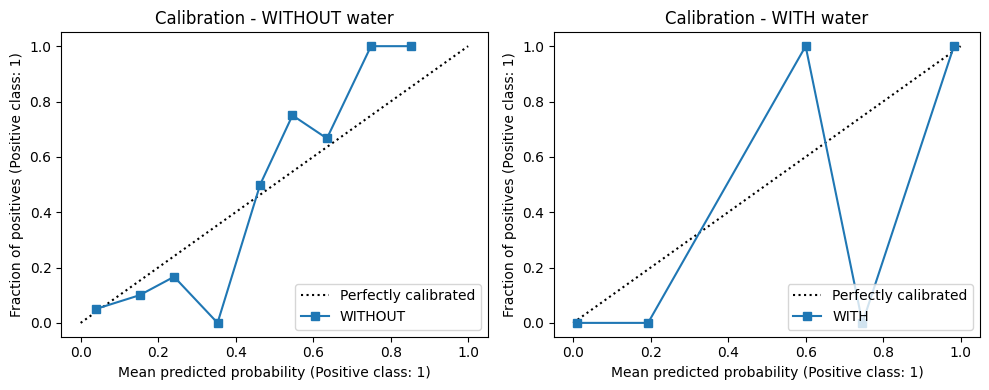

In [3]:
# Section 3: Calibration curves (probability reliability)
from sklearn.calibration import CalibrationDisplay

if (y_proba_with is not None) and (y_proba_without is not None):
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    CalibrationDisplay.from_predictions(y_test, y_proba_without, n_bins=10, name='WITHOUT', ax=axes[0])
    axes[0].set_title('Calibration - WITHOUT water')
    CalibrationDisplay.from_predictions(y_test, y_proba_with, n_bins=10, name='WITH', ax=axes[1])
    axes[1].set_title('Calibration - WITH water')
    plt.tight_layout(); plt.show()
else:
    print('Model has no predict_proba; skipping calibration.')


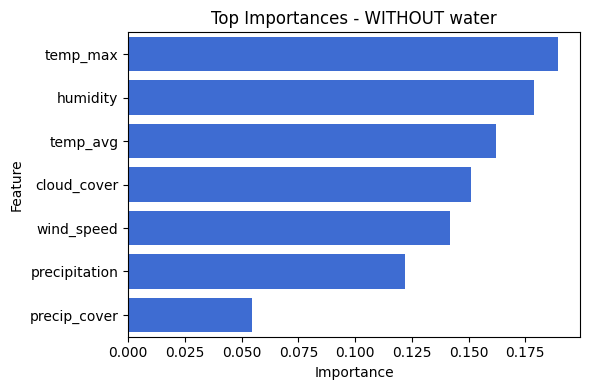

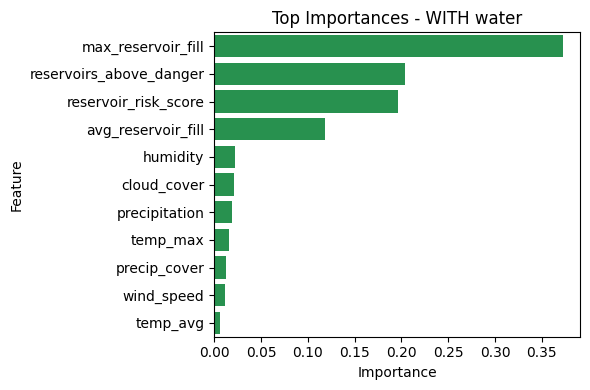

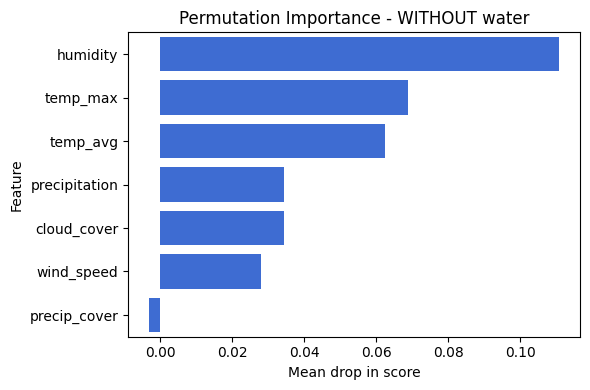

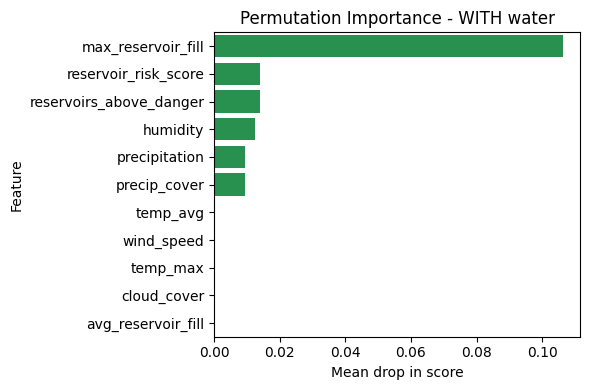

,mean_drop,std
Water features,0.386719,0.046842
Non-water features,0.035937,0.018554


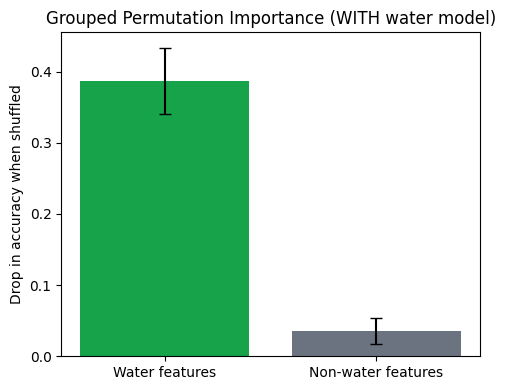

In [4]:
# Section 4: Feature importance and permutation importance (+ grouped importance)
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

# Gini importance (model-based)
def plot_top_importances(model, X, title, color):
    if hasattr(model, 'feature_importances_'):
        imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
        plt.figure(figsize=(6,4))
        sns.barplot(x=imp.values, y=imp.index, color=color, orient='h')
        plt.title(title); plt.xlabel('Importance'); plt.ylabel('Feature'); plt.tight_layout(); plt.show()
    else:
        print(f'{title}: model has no feature_importances_')

plot_top_importances(model_without, X_test_without, 'Top Importances - WITHOUT water', '#2563eb')
plot_top_importances(model_with, X_test_with, 'Top Importances - WITH water', '#16a34a')

# Permutation importance (on the same test set)
perm_wo = permutation_importance(model_without, X_test_without, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_w  = permutation_importance(model_with, X_test_with, y_test, n_repeats=10, random_state=42, n_jobs=-1)

def plot_perm(perm, cols, title, color):
    imp = pd.Series(perm.importances_mean, index=cols).sort_values(ascending=False).head(15)
    plt.figure(figsize=(6,4))
    sns.barplot(x=imp.values, y=imp.index, color=color, orient='h')
    plt.title(title); plt.xlabel('Mean drop in score'); plt.ylabel('Feature'); plt.tight_layout(); plt.show()

plot_perm(perm_wo, X_test_without.columns, 'Permutation Importance - WITHOUT water', '#2563eb')
plot_perm(perm_w,  X_test_with.columns,    'Permutation Importance - WITH water', '#16a34a')

# Grouped importance: water vs non-water (using permutation importance logic with repeated shuffles)
water_set = set(['avg_reservoir_fill','max_reservoir_fill','reservoir_risk_score','reservoirs_above_danger'])
water_cols = [c for c in X_test_with.columns if c in water_set]
nonwater_cols = [c for c in X_test_with.columns if c not in water_set]

def grouped_perm_importance(model, X, y, groups, n_repeats=20):
    base = model.score(X, y)
    drops = {}
    rng = np.random.default_rng(42)
    for name, cols in groups.items():
        drops_rep = []
        for _ in range(n_repeats):
            Xp = X.copy()
            for c in cols:
                if c in Xp.columns:
                    Xp[c] = rng.permutation(Xp[c].values)
            drops_rep.append(base - model.score(Xp, y))
        drops[name] = (float(np.mean(drops_rep)), float(np.std(drops_rep)))
    return drops

grp = {'Water features': water_cols, 'Non-water features': nonwater_cols}
grp_imp = grouped_perm_importance(model_with, X_test_with, y_test, grp, n_repeats=20)
df_grp = pd.DataFrame(grp_imp, index=['mean_drop','std']).T
display(df_grp)

plt.figure(figsize=(5,4))
plt.bar(df_grp.index, df_grp['mean_drop'], yerr=df_grp['std'], color=['#16a34a','#6b7280'], capsize=4)
plt.ylabel('Drop in accuracy when shuffled'); plt.title('Grouped Permutation Importance (WITH water model)')
plt.tight_layout(); plt.show()
